# **Install and Import Lib**

In [ ]:
# !pip install transformers tensorflow==2.12
# !huggingface-cli login <your token>

In [ ]:
# Import lib etc.
import pandas as pd
import tensorflow as tf
import re
from tensorflow.keras.layers import Dense, Embedding, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pengolahan Dataset

## Input Dataset

In [ ]:
# Load the data
data = pd.read_csv('/content/drive/MyDrive/Skripsi/Scrapping.csv',
                    encoding='latin1',
                    on_bad_lines='skip',
                    delimiter=';')

# Separate the data by label
data_0 = data[data['Label'] == 0]
data_1 = data[data['Label'] == 1]

# Print data distribution before resampling
print("Data distribution before resampling:")
print(data['Label'].value_counts())

# Resample the minority class (assuming class 1 is the minority)
data_1_resampled = resample(data_1,
                            replace=True,
                            n_samples=len(data_0),
                            random_state=42)

# Combine the resampled data with the majority class
resampled_data = pd.concat([data_0, data_1_resampled])

# Now proceed with text preprocessing using the resampled data
text_data = resampled_data['Headline'] + ' ' + resampled_data['Body'].fillna('')

# Encode categorical data (Label) using the resampled data
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(resampled_data['Label'])

# Print data distribution after resampling
print("\nData distribution after resampling:")
print(resampled_data['Label'].value_counts())

print("\nContoh Dataset:")
print(text_data.head(20))

Data distribution before resampling:
Label
0    683
1    433
Name: count, dtype: int64

Data distribution after resampling:
Label
0    683
1    683
Name: count, dtype: int64

Contoh Dataset:
433    Cacing Hidup di Sarden |  Living Worm in Sa...
434    Para Bajingan Tengik PKI Sudah Mulai Terang-t...
435    Terjadi Lagi Pembunuhan Terhadap Muadzin Nar...
436    Emil Salim Meninggal Beredar kabar di media pe...
437    Pengeroyokan Santri di Garut SUMBER: https://w...
438    Penyerangan Ulama di Pondok Pesantren Miftahul...
439    Pers Rilis Seketariat Presiden Menyebut Sri Mu...
440    Pesan Berantai Catut Kepolisian Soal Nama-nama...
441    Pesan Brimob Akan Sweeping Ojek Online di Wila...
442    Razia STNK Pada Tanggal 28 Februari 2018 Sumbe...
443    Rudi Hartono, Legenda Bulu Tangkis Meninggal P...
444    Ustaz di Cimahi Menghilang Pasca Salat Subuh S...
445    Video Telur Palsu Beredar di Ampenan Sumber: M...
446    Pembuat Desain Roti Al Maidah51 Sumber: Media ...
447    Kesa

## Pre-Procesing Dataset

In [ ]:
def preprocess_text(text):
    # Basic cleaning
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation and special characters
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Apply the preprocessing function to the text data
preprocessed_text_data = text_data.apply(preprocess_text)

print("\nData distribution after resampling:")
print(resampled_data['Label'].value_counts())
print("\nContoh Dataset:")
print(preprocessed_text_data.head(20))


Data distribution after resampling:
Label
0    683
1    683
Name: count, dtype: int64

Contoh Dataset:
433    cacing hidup di sarden living worm in sardine ...
434    para bajingan tengik pki sudah mulai terangter...
435    terjadi lagi pembunuhan terhadap muadzin naras...
436    emil salim meninggal beredar kabar di media pe...
437    pengeroyokan santri di garut sumber httpswwwfa...
438    penyerangan ulama di pondok pesantren miftahul...
439    pers rilis seketariat presiden menyebut sri mu...
440    pesan berantai catut kepolisian soal namanama ...
441    pesan brimob akan sweeping ojek online di wila...
442    razia stnk pada tanggal februari sumber whatsa...
443    rudi hartono legenda bulu tangkis meninggal pa...
444    ustaz di cimahi menghilang pasca salat subuh s...
445    video telur palsu beredar di ampenan sumber me...
446    pembuat desain roti al maidah sumber media sos...
447    kesalahan penulisan fitsa hats di bap kepolisi...
448    wn china datang ke jakarta untuk b

# Encoder (BERT) & Decoder (GPT2)

## Encoder Tokenizer

In [ ]:
# Tokenize the text
tokenizer = Tokenizer(num_words=1500, oov_token="<OOV>")
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=128)

# Encode categorical data (Label) using the resampled data
# This ensures consistency between input_features and labels
labels = label_encoder.fit_transform(resampled_data['Label'])

# Use the preprocessed data as input features
input_features = padded_sequences

# Define and use the BERT encoder
def bert_encoder(input_shape, vocab_size, embedding_dim=128):
    inputs = Input(shape=(input_shape[1],))
    x = Embedding(vocab_size, 64)(inputs)
    for _ in range(12):
        x = Dense(units=embedding_dim, activation='relu')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

vocab_size = len(tokenizer.word_index) + 1
encoder = bert_encoder(input_features.shape, vocab_size)
encoded_features = encoder(input_features)
print(encoded_features)

tf.Tensor(
[[[0.00000000e+00 0.00000000e+00 1.53989036e-04 ... 0.00000000e+00
   4.85390628e-05 4.64088429e-04]
  [0.00000000e+00 0.00000000e+00 1.29849606e-04 ... 7.63413991e-05
   7.74405780e-05 1.56717564e-04]
  [0.00000000e+00 0.00000000e+00 1.53989036e-04 ... 0.00000000e+00
   4.85390628e-05 4.64088429e-04]
  ...
  [0.00000000e+00 0.00000000e+00 1.67182719e-04 ... 0.00000000e+00
   2.79214990e-04 4.43781726e-04]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   1.44158752e-04 1.05762767e-04]
  [0.00000000e+00 0.00000000e+00 1.53989036e-04 ... 0.00000000e+00
   4.85390628e-05 4.64088429e-04]]

 [[0.00000000e+00 0.00000000e+00 1.62515629e-04 ... 0.00000000e+00
   1.45265542e-04 4.00441844e-04]
  [0.00000000e+00 0.00000000e+00 3.01131891e-04 ... 0.00000000e+00
   4.67560400e-04 1.58350755e-04]
  [0.00000000e+00 0.00000000e+00 4.41477314e-05 ... 0.00000000e+00
   4.04179416e-04 3.85543302e-04]
  ...
  [0.00000000e+00 0.00000000e+00 1.67182719e-04 ... 0.00000000e+00

## Decoder Tokenizer

# Hybrid Algorithm

## Concat Encoder (BERT) & Decoder (GPT2) Data

In [ ]:
# Load pre-trained GPT-2 model and tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = TFGPT2LMHeadModel.from_pretrained('gpt2')

if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

gpt2_tokenizer.model_max_length = 128

# Modified gpt2_decoder to accept encoded features
def gpt2_decoder(input_shape, vocab_size, embedding_dim=64):
    inputs = Input(shape=input_shape[1:])
    x = inputs
    # x = Embedding(vocab_size, 64)(inputs)
    for _ in range(12):
        x = Dense(units=embedding_dim, activation='relu')(x)
    outputs = Dense(vocab_size, activation='softmax')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


decoder = gpt2_decoder(encoded_features.shape, gpt2_tokenizer.vocab_size)
decoded_features = decoder(encoded_features)
print(decoded_features)

In [ ]:
# Concatenate BERT and GPT-2 outputs
combined_features = tf.keras.layers.Concatenate()([encoded_features, decoded_features])

## Split Dataset 80:20

In [ ]:
# Data split ratios
ratios = [(0.8, 0.2)]
for train_ratio, test_ratio in ratios:
  # Split the data using input_features and labels directly
  X_train, X_test, y_train, y_test = train_test_split(
      input_features, labels, test_size=test_ratio, random_state=42
  )
  print(f"Data split with ratio {train_ratio}:{test_ratio}")
  print("X_train shape:", X_train.shape)
  print("y_train shape:", y_train.shape)
  print("X_test shape:", X_test.shape)
  print("y_test shape:", y_test.shape)
  print("-" * 20)

Data split with ratio 0.8:0.2
X_train shape: (1092, 128)
y_train shape: (1092,)
X_test shape: (274, 128)
y_test shape: (274,)
--------------------


## Train Model GBERT

In [ ]:
# Define input layer using tf.keras.Input
input_layer = tf.keras.Input(shape=(input_features.shape[1],))

# Pass input_layer to the encoder to get encoded_features
encoded_features = encoder(input_layer)

# Pass encoded_features to the decoder to get decoded_features
decoded_features = decoder(encoded_features)

# Reshape decoded_features to have a compatible shape with encoded_features
# We want to reshape it to (None, 128, vocab_size), then reduce to (None, 128, 1) using GlobalAveragePooling1D
decoded_features = tf.keras.layers.Reshape((encoded_features.shape[1], gpt2_tokenizer.vocab_size))(decoded_features)
# Calculate the average across the vocabulary dimension (axis=2) instead of GlobalAveragePooling1D
decoded_features = tf.reduce_mean(decoded_features, axis=2, keepdims=True)
# Now decoded_features has shape (None, 128, 1)

# Concatenate BERT and GPT-2 outputs
combined_features = tf.keras.layers.Concatenate()([encoded_features, decoded_features])

# Tambahkan layer Dropout di sini
dropout_features = tf.keras.layers.Dropout(0.3)(combined_features)

# Add a dense layer with 64 neurons and ReLU activation
dense_layer = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(dropout_features)

# Apply GlobalAveragePooling1D to get a single representation
pooled_output = tf.keras.layers.GlobalAveragePooling1D()(dense_layer)

# Define the output layer (assuming binary classification)
output_layer = Dense(1, activation='sigmoid')(pooled_output)

# Create the model using input_layer and output_layer
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Buat instance optimizer dengan learning rate yang diinginkan
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
# Compile model dengan optimizer yang telah dibuat
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model and store the training history in the 'history' variable
history = model.fit(input_features, labels, epochs=10, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
39/39 [==============================] - 234s 6s/step - loss: 0.7383 - accuracy: 0.6957 - val_loss: 0.6684 - val_accuracy: 0.7883
Epoch 2/10
39/39 [==============================] - 224s 6s/step - loss: 0.2597 - accuracy: 0.9910 - val_loss: 0.3896 - val_accuracy: 0.9197
Epoch 3/10
39/39 [==============================] - 222s 6s/step - loss: 0.1425 - accuracy: 0.9935 - val_loss: 0.3332 - val_accuracy: 0.9343
Epoch 4/10
39/39 [==============================] - 222s 6s/step - loss: 0.1064 - accuracy: 0.9967 - val_loss: 0.3664 - val_accuracy: 0.9343
Epoch 5/10
39/39 [==============================] - 222s 6s/step - loss: 0.0927 - accuracy: 0.9984 - val_loss: 0.3655 - val_accuracy: 0.9343
Epoch 6/10
39/39 [==============================] - 221s 6s/step - loss: 0.0848 - accuracy: 0.9984 - val_loss: 0.3893 - val_accuracy: 0.9343


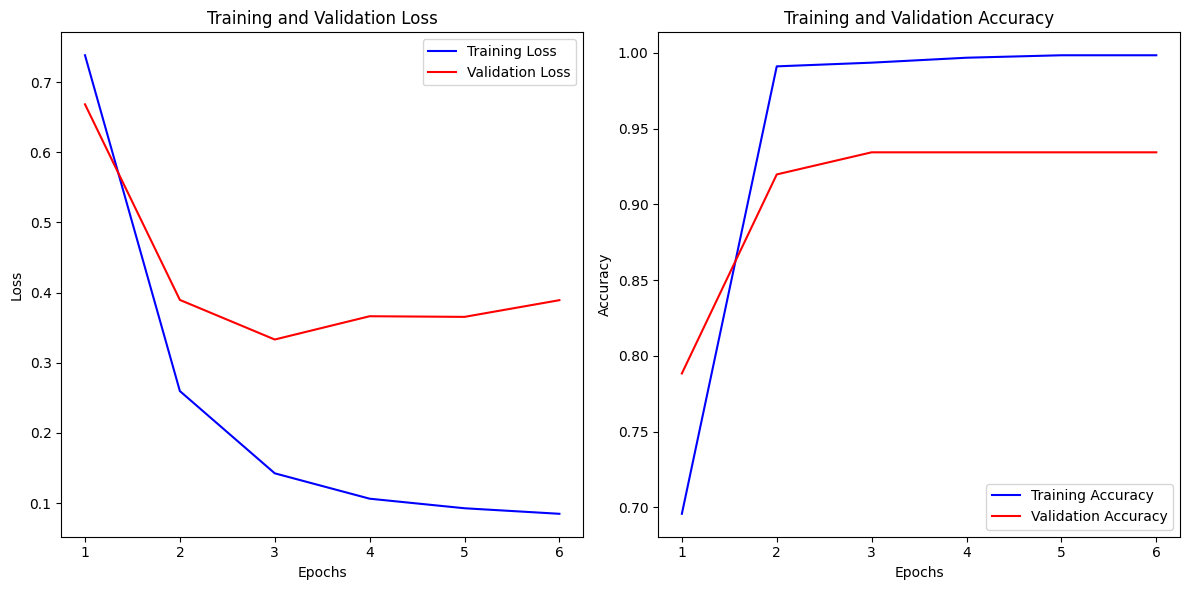

In [ ]:
# Access the training and validation loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create the plot
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation Matrix

In [ ]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
cm

9/9 [==============================] - 17s 2s/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:


array([[143,   0],
       [  0, 131]])

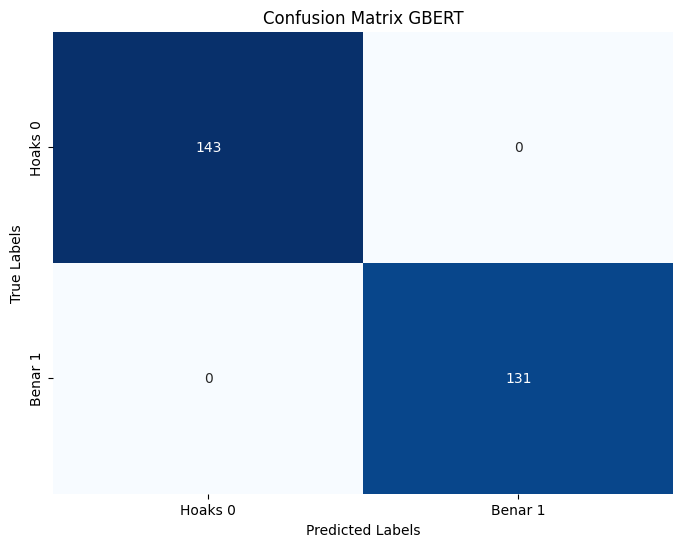

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Hoaks 0', 'Benar 1'],
            yticklabels=['Hoaks 0', 'Benar 1'])
plt.title("Confusion Matrix GBERT")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()